#  Subject:Real-Time Emotion Tracking from Video Frames (Facial Expression + LSTM)

My project uses facial expression images to predict emotions in real-time using deep learning.  
I applied CNN + LSTM architecture and evaluated the model on standard metrics like accuracy, precision, recall, and F1-score.


#  Dataset Loading

I used a public dataset that contains face images organized by emotion labels (happy, sad, angry, etc.).  
The images are loaded from `train` and `test` folders using TensorFlow's `image_dataset_from_directory`.
The link of my dataset is --> https://www.kaggle.com/datasets/msambare/fer2013


#  Data Preprocessing

Before training  I preprocessed the images:
. By converting them to grayscale
. By resizing them to 48x48 pixels
. By normalizing pixel values to range [0, 1]


In [ ]:
import tensorflow as tf

# Setting the directory paths for training and testing images
train_dir = "dataset/train" 
test_dir = "dataset/test"

# Setting image size and batch size
img_size = (48, 48)
batch_size = 32

# Loading training dataset from folders
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)
# Loading testing dataset from folders
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)
# Showing class names 
class_names = train_ds.class_names
print("Classes:", class_names)


#  Data Augmentation

To improve model performance I applied data augmentation:
. Random flipping (horizontal and vertical)
. Rotation and zoom
. Contrast changes and cropping

This prevents overfitting.
Below you can see some examples.


In [2]:
from tensorflow.keras import layers

# Defining data augmentation
data_augmentation = tf.keras.Sequential([
    layers.Rescaling(1./255),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomCrop(48, 48), 
    layers.RandomContrast(0.2)
])



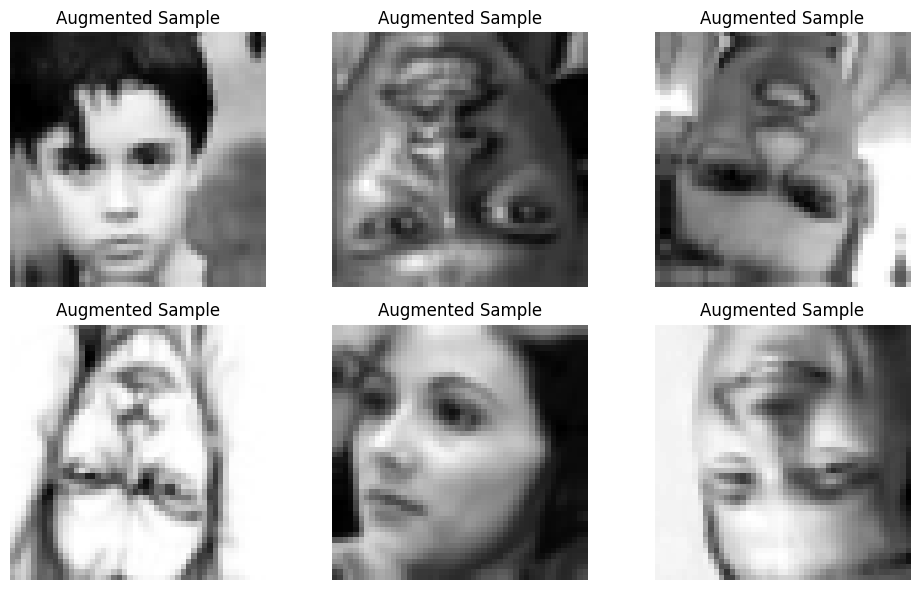

In [3]:
import matplotlib.pyplot as plt

for images, _ in train_ds.take(1):
    augmented_images = data_augmentation(images)
    plt.figure(figsize=(10, 6))
    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(tf.squeeze(augmented_images[i]), cmap='gray')
        plt.title("Augmented Sample")
        plt.axis("off")
    plt.tight_layout()
    plt.show()
    break


#  Model Building and Training

I builded a deep learning model using:
. CNN layers to extract features from images
. LSTM layer to process image sequences 



In [4]:
from tensorflow.keras import Sequential, layers

# Building CNN + LSTM model
model = Sequential([
    layers.TimeDistributed(data_augmentation, input_shape=(1, 48, 48, 1)),
    layers.TimeDistributed(layers.Conv2D(32, (3, 3), activation='relu')),
    layers.TimeDistributed(layers.MaxPooling2D((2, 2))),
    layers.TimeDistributed(layers.Conv2D(64, (3, 3), activation='relu')),
    layers.TimeDistributed(layers.MaxPooling2D((2, 2))),
    layers.TimeDistributed(layers.Flatten()),
    layers.LSTM(64),
    layers.Dense(len(class_names), activation='softmax')
])

# Compiling the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


C:\Users\Umut Can Uzun\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 1, 48, 48, 1)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 1, 46, 46, 32)       │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 1, 23, 23, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 1, 21, 21, 64)       │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 1, 10, 10, 64)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 1, 6400)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │       1,655,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,674,311 (6.39 MB)

 Trainable params: 1,674,311 (6.39 MB)

 Non-trainable params: 0 (0.00 B)

# Evaluation and Metrics

I tested the model on unseen data.  
I calculated and report:
. Accuracy
. Precision
. Recall
. F1 Score
. Confusion Matrix 

These metrics show how well the model performs on each emotion class.


In [5]:
from tensorflow.keras.callbacks import EarlyStopping

train_seq = train_ds.map(lambda x, y: (tf.expand_dims(x, 1), y))
test_seq = test_ds.map(lambda x, y: (tf.expand_dims(x, 1), y))

# Stop training early if validation loss doesn't improve for 3 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Training the model
history = model.fit(
    train_seq,
    validation_data=test_seq,
    epochs=10,
    callbacks=[early_stop]
)


Epoch 1/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 78s 82ms/step - accuracy: 0.2601 - loss: 1.7920 - val_accuracy: 0.3175 - val_loss: 1.6884
Epoch 2/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 78s 87ms/step - accuracy: 0.3259 - loss: 1.6878 - val_accuracy: 0.3789 - val_loss: 1.5872
Epoch 3/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 76s 85ms/step - accuracy: 0.3779 - loss: 1.5770 - val_accuracy: 0.4139 - val_loss: 1.4997
Epoch 4/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 83s 92ms/step - accuracy: 0.4055 - loss: 1.5158 - val_accuracy: 0.4348 - val_loss: 1.4488
Epoch 5/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 78s 86ms/step - accuracy: 0.4309 - loss: 1.4594 - val_accuracy: 0.4500 - val_loss: 1.4047
Epoch 6/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 71s 79ms/step - accuracy: 0.4469 - loss: 1.4309 - val_accuracy: 0.4586 - val_loss: 1.3923
Epoch 7/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 70s 78ms/step - accuracy: 0.4564 - loss: 1.3986 - val_accuracy: 0.4724 - val_loss: 1.3553
Epoch 8/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 70s 78ms/step - accuracy: 0.4773 - loss: 1.3681 - 

In [6]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_true, y_pred = [], []

# Predicting on the test set
for x, y in test_seq:
    preds = model.predict(x)
    y_true.extend(np.argmax(y.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(y_true, y_pred, target_names=class_names))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━

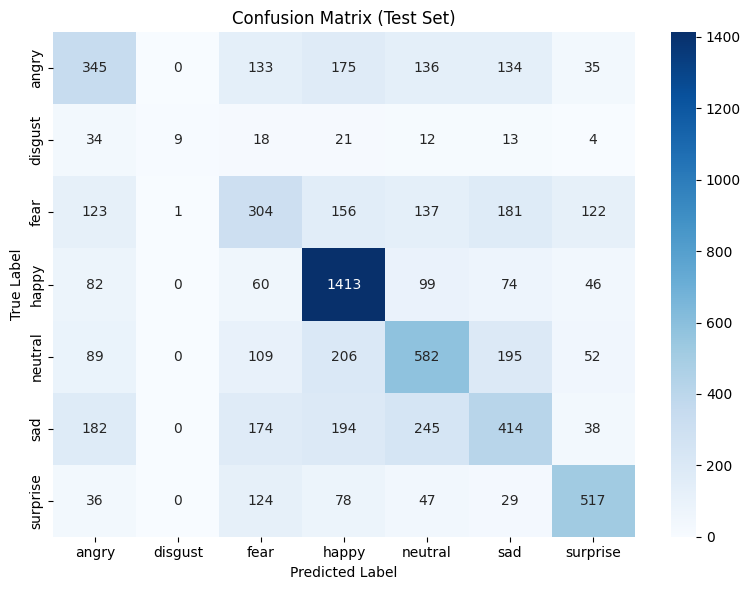

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Confusion matrix counting
cm = confusion_matrix(y_true, y_pred)

# Imaging
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Test Set)')
plt.tight_layout()
plt.show()


# Results and Visualization

Here:
. Training and validation accuracy over epochs
. Confusion matrix as a heatmap

These graphs help us understand model performance clearly.


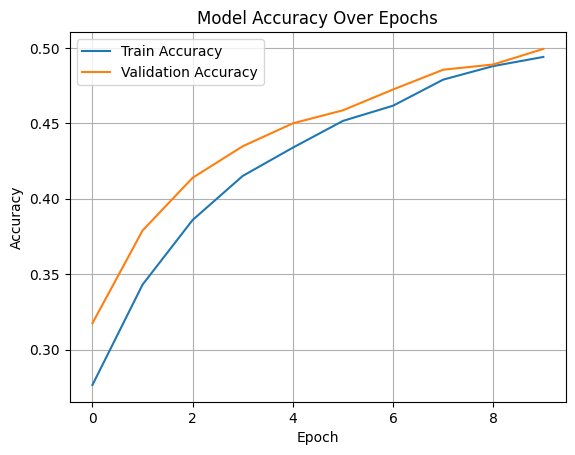

In [8]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.title("Model Accuracy Over Epochs")
plt.show()


# Conclusion

This project successfully predicts human emotions from face images using CNN and LSTM.  
Data augmentation and evaluation helped to improve model accuracy and reliability.
